# Data split

In [63]:
%reset -f

In [64]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import numpy as np
import datetime

In [65]:
# convert images to PyTorch tensors
"""transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
"""
# Second attempt to solve overfitting
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [66]:
data_dir = '/exchange/dspro01/group3/data/train' 
dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name


In [67]:
# For reproducibility
seed = 42
torch.manual_seed(seed)

In [68]:
total_size = len(dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size) 

In [69]:
# Split
generator = torch.Generator().manual_seed(seed) # For reproducibility
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator) 

In [70]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Model

In [71]:
from torchvision import models
import torch.nn as nn

In [72]:
# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

In [73]:
# Create dataset_sizes dictionary for calculating losses and accuracies
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

### Training & Validation loop

In [74]:
# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_roc_aucs = []
val_conf_matrices = []

# Early Stopping Parameters
patience = 5
early_stopping_counter = 0
best_epoch = 0

# Track the best model
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_val_accuracy = 0.0
best_model_path = f'best_model_{current_time}.pth'

# Define a new model with additional CNN layers
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        # Load the pre-trained ResNet
        self.base_model = models.resnet50(pretrained=True)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2]) # Exclude FC and pooling layers

        # Freeze pretrained layers
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # Additional CNN layers
        self.additional_layers = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.additional_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc(x) # Fully connected
        return x


In [75]:
# Move the model to a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

# Instantiate the model
num_classes = 12 
model = TransferLearningModel(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 


In [79]:
# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_conf_matrices = []

# Early Stopping Parameters
patience = 5
early_stopping_counter = 0
best_val_accuracy = 0.0
best_epoch = 0

# Track the best model
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_model_path = f'best_model_{current_time}.pth'

num_epochs = 40   # Set the number of epochs

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)  # Forward pass through the custom model
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

        # Convert lists to numpy arrays for metric calculations
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics for later plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Calculate F1-Score for validation phase
            f1 = f1_score(all_labels, all_preds, average='weighted')
            val_f1_scores.append(f1)

            # Confusion Matrix
            conf_matrix = confusion_matrix(all_labels, all_preds)
            val_conf_matrices.append(conf_matrix)

            # Save the best model based on validation accuracy
            if epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_epoch = epoch + 1
                early_stopping_counter = 0  # Reset the counter
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'accuracy': best_val_accuracy,
                }, best_model_path)
                print(f'Saved best model at epoch {epoch + 1} with validation accuracy: {best_val_accuracy:.4f}')
            else:
                early_stopping_counter += 1  # Increment the counter

    scheduler.step()

    # Early stopping condition
    if early_stopping_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        print(f'Best validation accuracy achieved at epoch {best_epoch}: {best_val_accuracy:.4f}')
        break

print('Training complete')


Epoch 1/40
----------
train Loss: 1.1513 Acc: 0.5858
val Loss: 1.0953 Acc: 0.5957
Saved best model at epoch 1 with validation accuracy: 0.5957
Epoch 2/40
----------
train Loss: 1.1205 Acc: 0.5973
val Loss: 1.0746 Acc: 0.6142
Saved best model at epoch 2 with validation accuracy: 0.6142
Epoch 3/40
----------
train Loss: 1.0832 Acc: 0.6101
val Loss: 1.0761 Acc: 0.6057
Epoch 4/40
----------
train Loss: 1.0810 Acc: 0.6112
val Loss: 1.0596 Acc: 0.6144
Saved best model at epoch 4 with validation accuracy: 0.6144
Epoch 5/40
----------
train Loss: 1.0564 Acc: 0.6194
val Loss: 1.0448 Acc: 0.6123
Epoch 6/40
----------
train Loss: 1.0368 Acc: 0.6265
val Loss: 1.0080 Acc: 0.6339
Saved best model at epoch 6 with validation accuracy: 0.6339
Epoch 7/40
----------
train Loss: 1.0196 Acc: 0.6334
val Loss: 1.0053 Acc: 0.6316
Epoch 8/40
----------
train Loss: 0.9554 Acc: 0.6549
val Loss: 0.9605 Acc: 0.6498
Saved best model at epoch 8 with validation accuracy: 0.6498
Epoch 9/40
----------
train Loss: 0.932

### Save data

In [80]:
import pandas as pd

# Create a dictionary for your data
data = {
    "epoch": range(1, len(train_losses) + 1),  # Epochs start from 1
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
    "val_f1_score": val_f1_scores,
    "val_conf_matrix": val_conf_matrices
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Save to a CSV file
file_name = f"training_results_CNN_{current_time}.csv"
df.to_csv(file_name, index=False)


# Visualization

In [36]:
len(train_losses)

24

ValueError: x and y must have same first dimension, but have shapes (22,) and (24,)

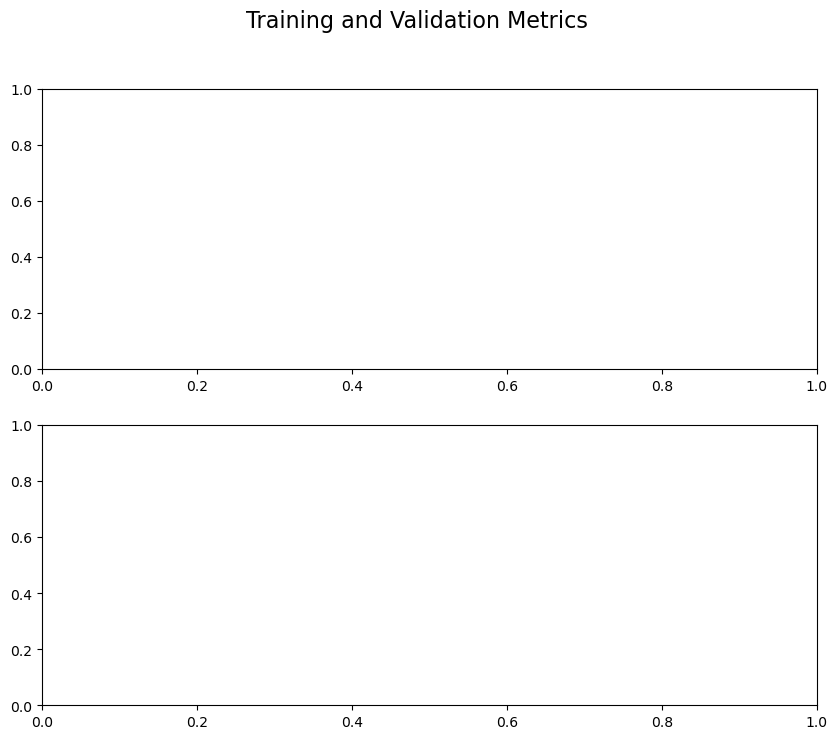

In [38]:
import matplotlib.pyplot as plt
import numpy as np

stopped_epoch = best_epoch + patience

# Data from your training output
epochs = range(1, stopped_epoch+1) ## HARD CODDED stopped_epoch
           
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 3)
ax1.set_xlim(1)
ax1.legend()
ax1.grid()


# Plot training & validation accuracy values
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 3)
ax2.set_xlim(1)
ax.set_xticks(ticks=np.arange(1, stopped_epoch+1, 1)) # HARD CODED, epochs
ax2.legend()
ax2.grid()

# Adjust layout and display the plot
fig.tight_layout()
ax1.plot()
ax2.plot()
f.show()

# Calculate and print best validation accuracy
best_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_accuracy) + 1
print(f"Best validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")


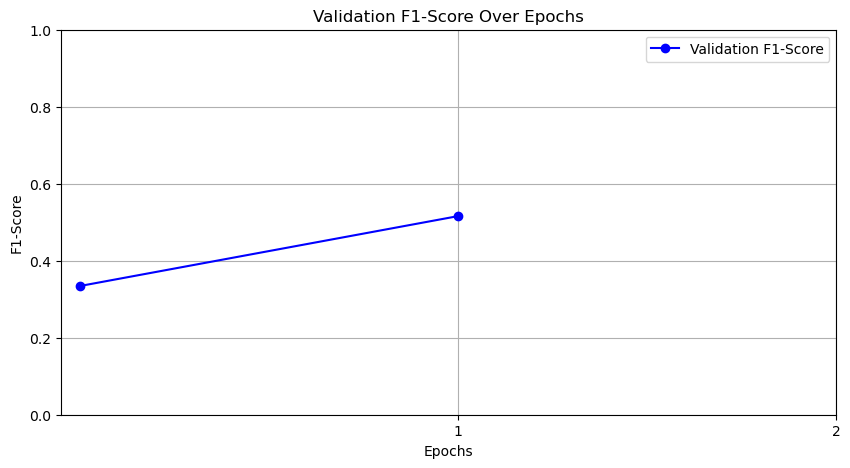

In [34]:
# Plot F1-Score
f, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax.plot(val_f1_scores, label='Validation F1-Score', marker='o', color='blue')
ax.set_xlabel('Epochs', loc='center')
ax.set_ylabel('F1-Score')
ax.set_title('Validation F1-Score Over Epochs')
ax.set_ylim(0, 1)
ax.set_xticks(ticks=np.arange(1, 3, 1)) # HARD CODED
ax.legend()
ax.grid()
f.show()

2


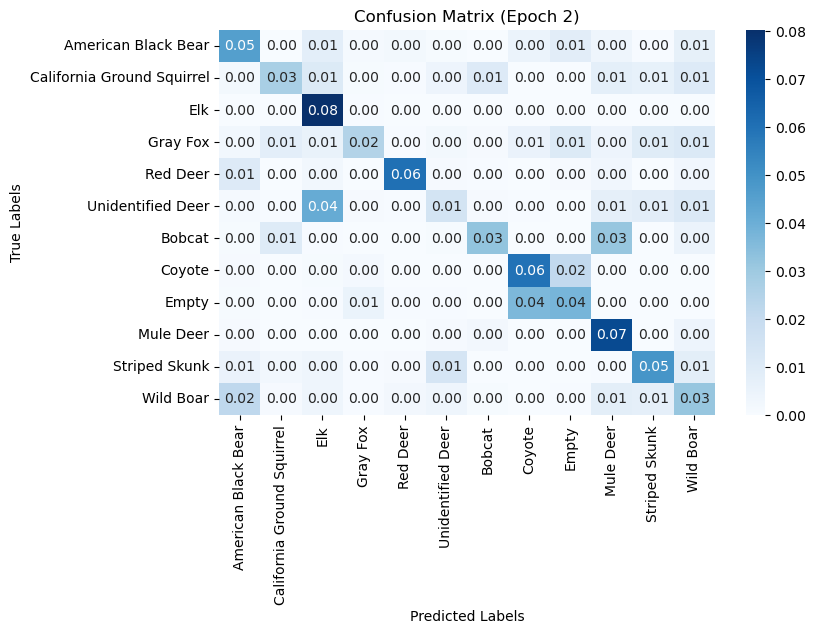

In [27]:
import seaborn as sns
print(best_epoch)
# Confusion Matrix for the Best Epoch
conf_matrix = val_conf_matrices[best_epoch - 1]  # Index corresponds to the best epoch
class_names = ['American Black Bear', 'California Ground Squirrel', 'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 'Striped Skunk', 'Wild Boar']  # TODO CLASSES NAMES

f, ax = plt.subplots(figsize=(8, 5), sharex=True)
sns.heatmap(conf_matrix/ (len(val_dataset)/num_classes), annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Confusion Matrix (Epoch {best_epoch})')
f.show()


# Use trained model

--> take out dense layer and add dense layers
backbone for feature extraction - then dense layers
-- just use the backbone not the dense layers. Freez backbone and train dense layer

